In [71]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# SKTIME

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.ets import AutoETS

from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.arima import ARIMA

In [73]:
# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose


In [74]:


reservas = pd.read_csv('reservas.csv',sep=',')
cancelaciones = pd.read_csv('cancelaciones.csv',sep=',')

reservas.head()


,Arrival,Bookings
0,2015-07-05,85
1,2015-07-12,61
2,2015-07-19,124
3,2015-07-26,134
4,2015-08-02,77


In [75]:
cancelaciones.head()

,Arrival,IsCanceled
0,2015-07-05,190
1,2015-07-12,224
2,2015-07-19,341
3,2015-07-26,452
4,2015-08-02,232


In [76]:

cancelaciones['Arrival'] = pd.to_datetime(cancelaciones['Arrival'])
cancelaciones.set_index('Arrival', inplace=True)
cancelaciones.index = cancelaciones.index.to_period('W')

reservas['Arrival'] = pd.to_datetime(reservas['Arrival'])
reservas.set_index('Arrival', inplace=True)
reservas.index = reservas.index.to_period('W')


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

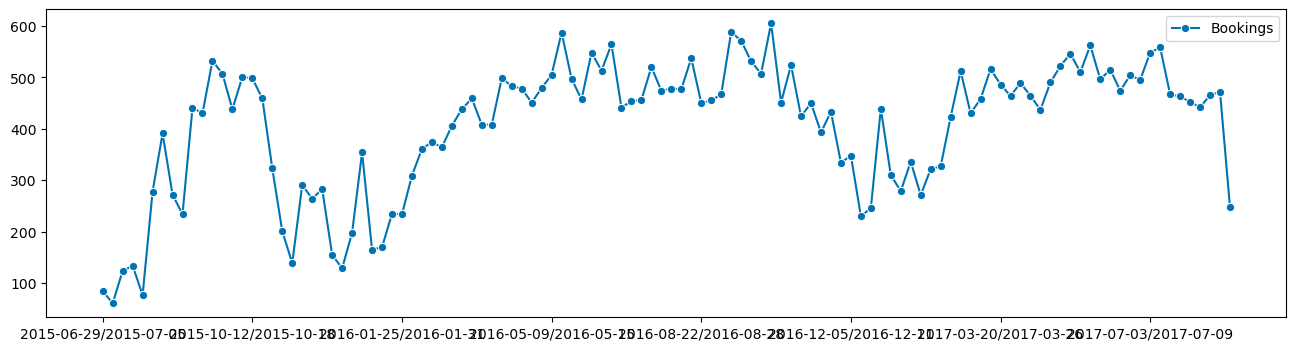

In [77]:

import matplotlib.pyplot as plt
import seaborn as sns
#sktime
plot_series(reservas, labels=["Bookings"])



(<Figure size 1600x400 with 1 Axes>, <Axes: >)

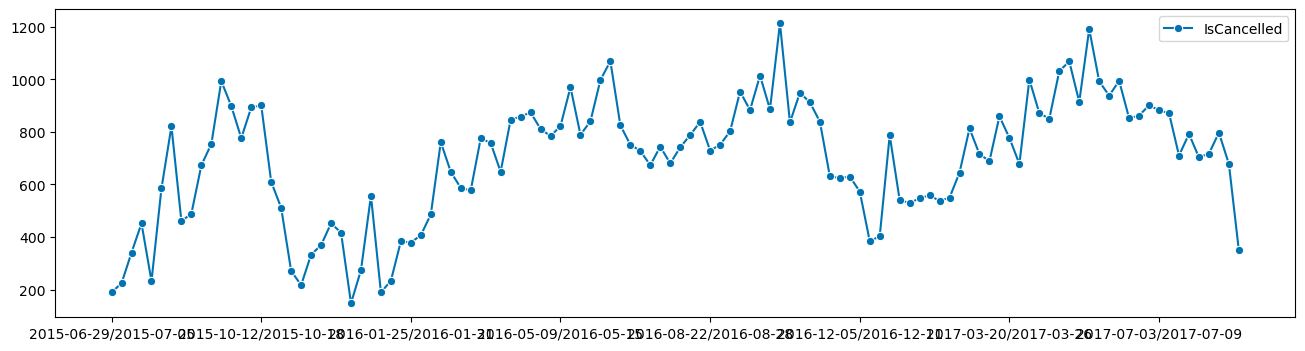

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
#sktime
plot_series(cancelaciones, labels=["IsCancelled"])



## Estacionalidad, Componentes y estacionariedad

### Cancelaciones

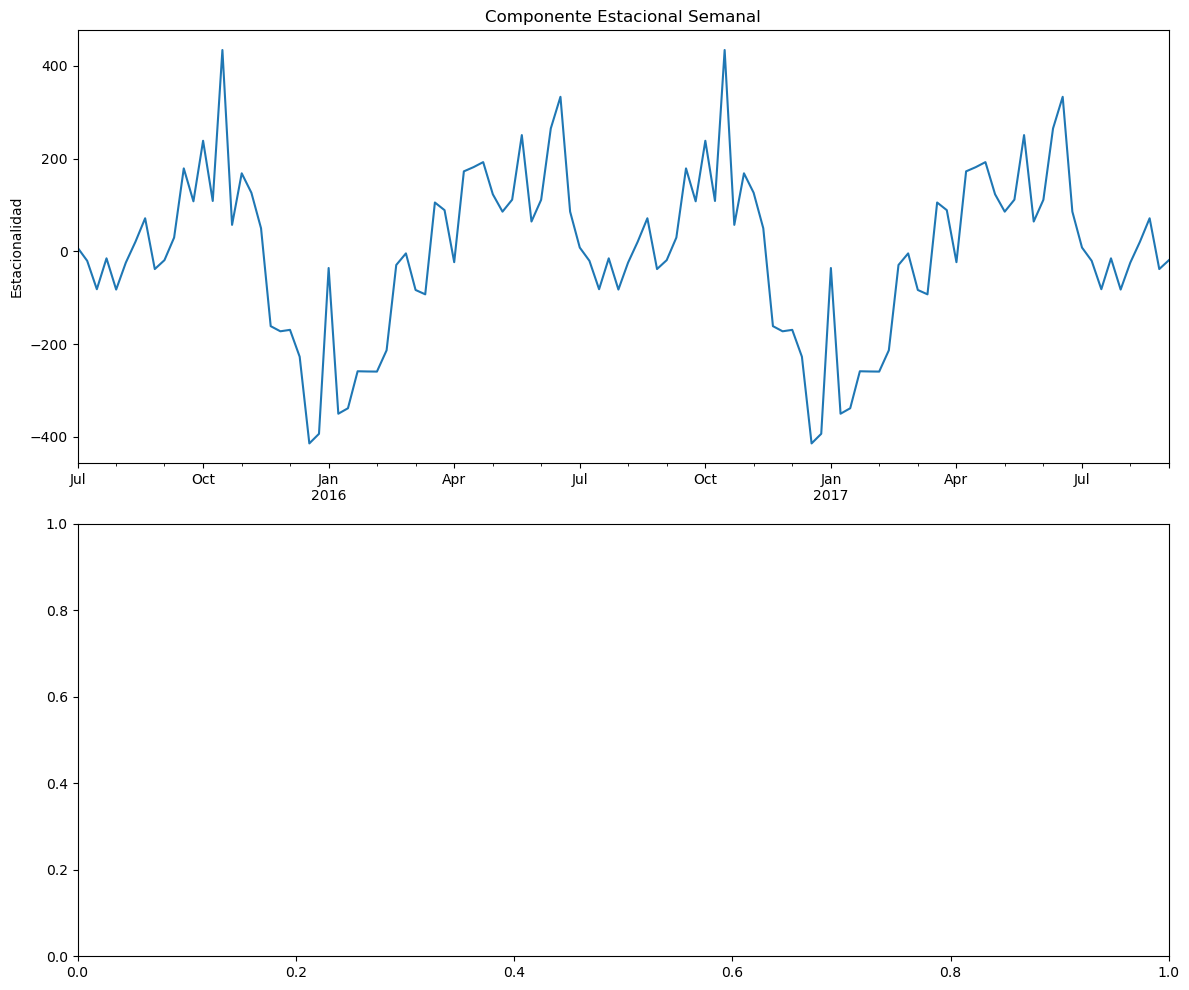

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizar la descomposición estacional
can_seas = seasonal_decompose(cancelaciones, period=52)  # Asignamos la frecuencia semanal (52 semanas)

# Graficar la estacionalidad semanal
fig, axes = plt.subplots(2, figsize=(12, 10))
can_seas.seasonal.plot(ax=axes[0])
axes[0].set_ylabel('Estacionalidad')
axes[0].set_title('Componente Estacional Semanal')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


In [180]:
# Descomposición y tendencia
can_seas = seasonal_decompose(cancelaciones)
fig = can_seas.plot()
fig.set_size_inches((12, 10))
plt.show()

TypeError: PeriodIndex given. Check the `freq` attribute instead of using infer_freq.

### Reservas

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizar la descomposición estacional
res_seas = seasonal_decompose(reservas, period=52)  # Asignamos la frecuencia semanal (52 semanas)

# Graficar la estacionalidad semanal
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
res_seas.seasonal.plot(ax=axes[0])
axes[0].set_ylabel('Estacionalidad')
axes[0].set_title('Componente Estacional Semanal')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()

In [79]:
# Crear Train short, Train, val & test
res_train, res_test = temporal_train_test_split(reservas, test_size=6)
res_train_short, res_val_test = temporal_train_test_split(reservas, test_size=18)
res_val, res_test_2 = temporal_train_test_split(y = res_val_test, test_size=6)
# Tamaño
print("res_train: ",res_train.shape)
print("res_train_short: ",res_train_short.shape)
print("res_test: ",res_test.shape)
print("res_val: ",res_val.shape)

res_train:  (108, 1)
res_train_short:  (96, 1)
res_test:  (6, 1)
res_val:  (12, 1)


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

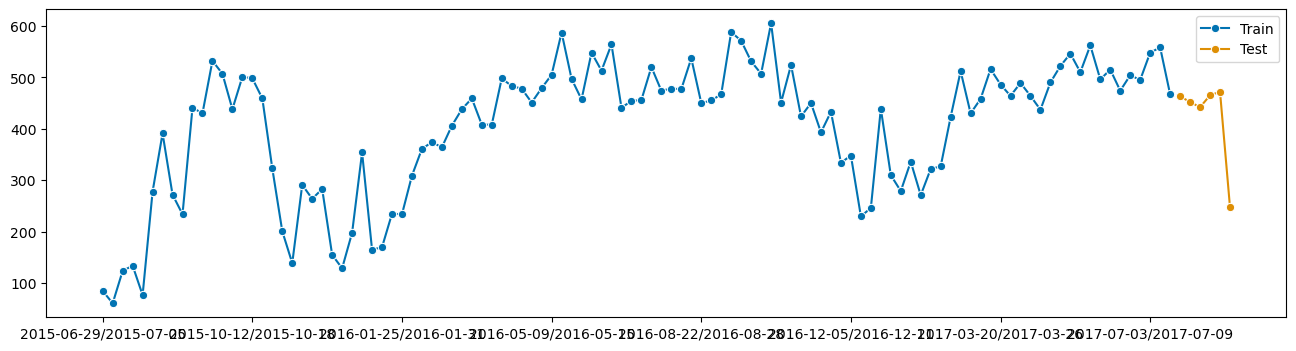

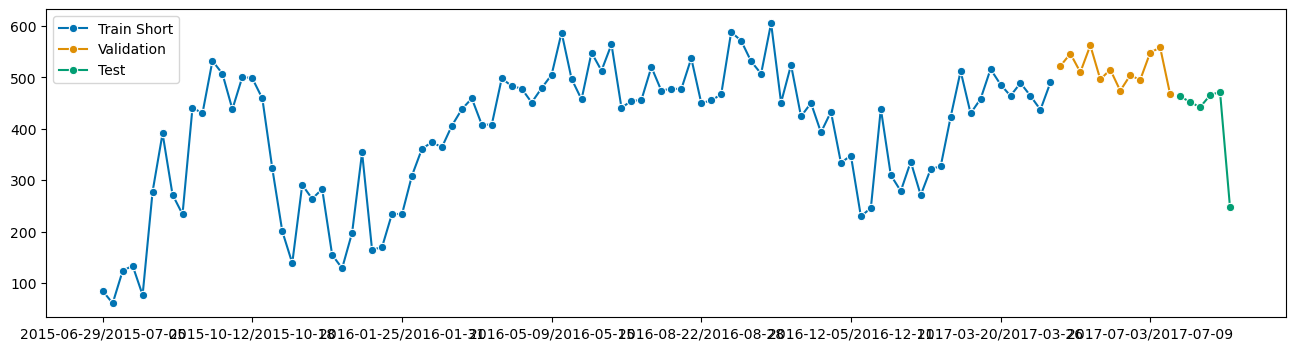

In [80]:
# Graficar Train short, Train, val & test
plot_series(res_train, res_test, labels=["Train", "Test"])
plot_series(res_train_short,res_val, res_test, labels=["Train Short","Validation", "Test"])

In [81]:
# Crear Train short, Train, val & test
can_train, can_test = temporal_train_test_split(cancelaciones, test_size=6)
can_train_short, can_val_test = temporal_train_test_split(cancelaciones, test_size=18)
can_val, can_test_2 = temporal_train_test_split(y = can_val_test, test_size=6)
# Tamaño
print("can_train: ",can_train.shape)
print("can_train_short: ",can_train_short.shape)
print("can_test: ",can_test.shape)
print("can_val: ",can_val.shape)

can_train:  (108, 1)
can_train_short:  (96, 1)
can_test:  (6, 1)
can_val:  (12, 1)


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

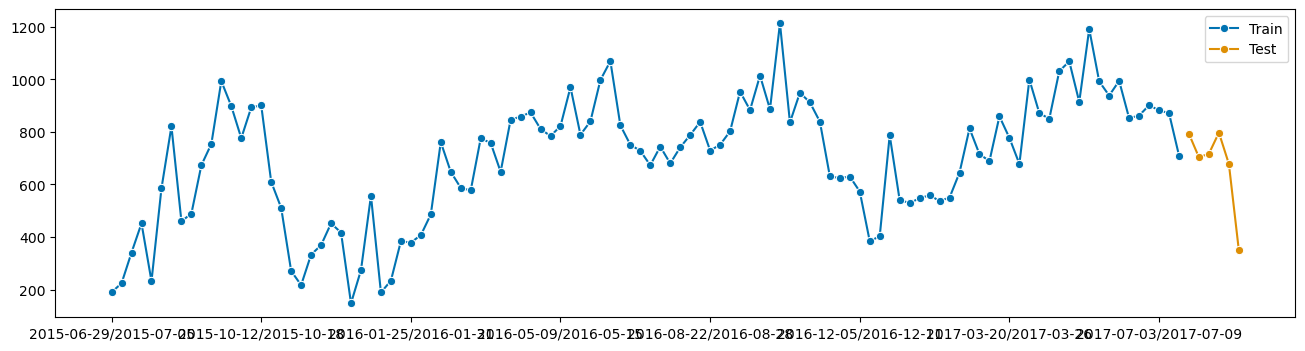

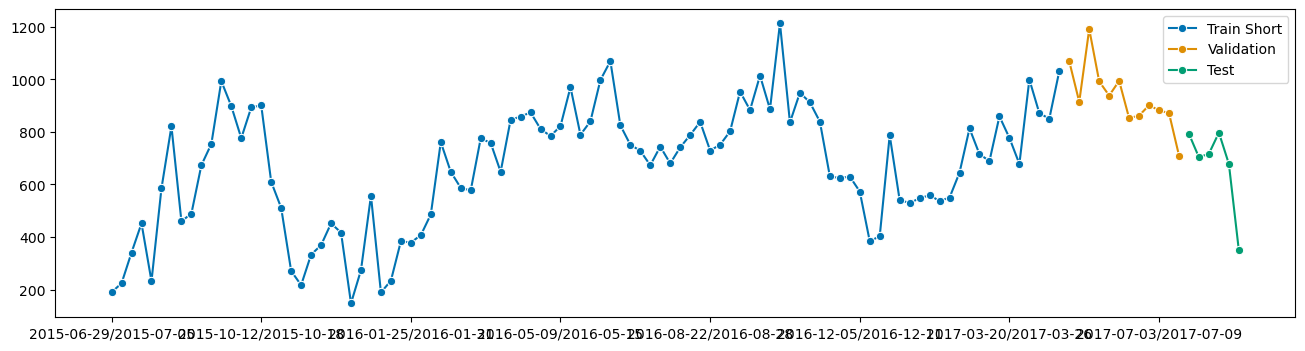

In [82]:
# Graficar Train short, Train, val & test
plot_series(can_train, can_test, labels=["Train", "Test"])
plot_series(can_train_short,can_val, can_test, labels=["Train Short","Validation", "Test"])

## ETS

### Cancelaciones



In [83]:
from sktime.forecasting.ets import AutoETS

# Definimos el modelo AutoETS
ets_model_cancelaciones = AutoETS(auto=True, n_jobs=-1, sp=52)  

# Estimamos el modelo usando los datos de cancelaciones
ets_model_cancelaciones.fit(can_train) 

# Imprimimos un resumen del modelo ajustado
print(ets_model_cancelaciones.summary())


                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  108
Model:                      ETS(AAdA)   Log Likelihood                -622.283
Date:                Thu, 21 Dec 2023   AIC                           1362.566
Time:                        16:37:31   BIC                           1520.812
Sample:                    07-05-2015   HQIC                          1426.729
                         - 07-23-2017   Scale                         5918.777
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6198      0.113      5.473      0.000       0.398       0.842
smoothing_trend      6.198e-05        nan        nan        nan         nan         nan
smoothing_season

In [84]:
 # Predicción
fh_test_can= np.arange(1,len(can_test)+1)
ets_pred = ets_model_cancelaciones.predict(fh=fh_test_can)
ets_pred

,IsCanceled
2017-07-24/2017-07-30,616.204426
2017-07-31/2017-08-06,796.873936
2017-08-07/2017-08-13,906.787628
2017-08-14/2017-08-20,735.548613
2017-08-21/2017-08-27,691.726189
2017-08-28/2017-09-03,785.548639


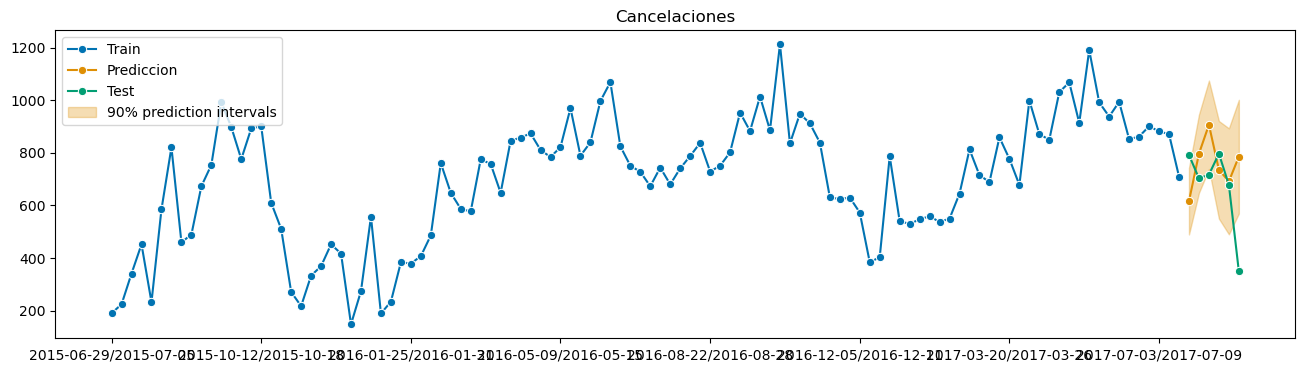

In [151]:
# Generamos los intervalos de predicción
ets_ip = ets_model_cancelaciones.predict_interval(fh_test_can, coverage=0.9)

# Graficamos las series y predicciones
fig, ax = plot_series(can_train, ets_pred, can_test, labels=["Train", "Prediccion", "Test"])

# Rellenamos el área entre los intervalos de predicción
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_ip.iloc[:, 0],  # Accedemos a la primera columna para obtener el límite inferior
    ets_ip.iloc[:, 1],  # Accedemos a la segunda columna para obtener el límite superior
    alpha=0.3,
    color=ax.get_lines()[-2].get_c(),
    label="90% prediction intervals"
)
ax.set_title('Cancelaciones')

# Mostramos la leyenda
ax.legend(loc='upper left')


In [86]:
# Performance
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
RMSE = MeanSquaredError(square_root=True)
MAPE = MeanAbsolutePercentageError(symmetric=False)

def ForecastPerformance(original,forecast):
    print(f'RMSE: {round(RMSE(original, forecast),2)}')
    print(f'MAPE: {round(MAPE(original, forecast)*100,2)}%')

In [87]:
# Calcular Performance

ForecastPerformance(can_test, ets_pred)

RMSE: 212.24
MAPE: 32.81%


### Cross Validation Cancelaciones


In [88]:
# Cross Validation
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster



# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])
# Defenir el CV
cv = ExpandingWindowSplitter(
    initial_window=50, #60 114
     step_length=1,
    # start_with_window=True,
     fh=fh_test_can) # fh_test 1 
# definir los modelos y los parametros (GRID)
cancv = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
     {
          "forecaster": [ExponentialSmoothing(sp=52)],
          "forecaster__trend": ["add", "mul"],
          "forecaster__damped_trend": [True,False],
          "forecaster__seasonal": ["add", "mul"],
    },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)


In [89]:
# estimar todos los modelos pot CV 
cancv.fit(can_train)  

Fitting 53 folds for each of 11 candidates, totalling 583 fits


c:\Users\Manuel\anaconda3\Lib\site-packages\sktime\forecasting\naive.py:170: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=50),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ExponentialSmoothing(sp=52)],
                                     'forecaster__damped_trend': [True, False],
                                     'forecaster__seasonal': ['add', 'mul'],
                                     'forecaster__trend': ['add', 'mul']}],
                        verbose=1)

In [90]:
# Los resultados
cancv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.207705,0.043227,0.032856,"{'forecaster': NaiveForecaster(sp=52, strategy...",1.0
1,0.253545,0.021622,0.218282,"{'forecaster': NaiveForecaster(sp=52), 'foreca...",2.0
2,0.262020,0.048472,0.032258,"{'forecaster': NaiveForecaster(sp=52, strategy...",3.0
3,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
4,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
5,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
6,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
7,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(seasonal='...,NaN
8,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(seasonal='...,NaN
9,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(seasonal='...,NaN


In [ ]:
# estimar todos los modelos pot CV 
cancv.fit(can_train)  
# el tercer modelo
cancv.cv_results_["params"][3]
# El performance del mejor modelo
cancv.best_score_
# Predicción
can_cv_pred = cancv.predict(fh=[1,2,3,4,5,6]) 
can_cv_pred


Fitting 53 folds for each of 11 candidates, totalling 583 fits


c:\Users\Manuel\anaconda3\Lib\site-packages\sktime\forecasting\naive.py:170: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")


,IsCanceled
2017-07-24/2017-07-30,714.859813
2017-07-31/2017-08-06,719.719626
2017-08-07/2017-08-13,724.579439
2017-08-14/2017-08-20,729.439252
2017-08-21/2017-08-27,734.299065
2017-08-28/2017-09-03,739.158879


### Reservas

In [91]:
from sktime.forecasting.ets import AutoETS

# Suponiendo que ya tienes reservas como tu serie temporal de entrenamiento

# Definimos el modelo AutoETS
ets_model_res = AutoETS(auto=True, n_jobs=-1, sp=52)  

# Estimamos el modelo usando los datos de entrenamiento
ets_model_res.fit(res_train) 

# Imprimimos un resumen del modelo ajustado
print(ets_model_res.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  108
Model:                      ETS(AAdA)   Log Likelihood                -553.474
Date:                Thu, 21 Dec 2023   AIC                           1224.949
Time:                        16:38:07   BIC                           1383.195
Sample:                    07-05-2015   HQIC                          1289.112
                         - 07-23-2017   Scale                         1655.155
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2439      0.112      2.179      0.029       0.025       0.463
smoothing_trend      2.439e-05      0.069      0.000      1.000      -0.135       0.135
smoothing_season

In [92]:
 # Predicción
fh_test_res= np.arange(1,len(res_test)+1)
ets_pred_res = ets_model_res.predict(fh=fh_test_res)
ets_pred_res

,Bookings
2017-07-24/2017-07-30,408.628006
2017-07-31/2017-08-06,491.356148
2017-08-07/2017-08-13,530.169175
2017-08-14/2017-08-20,486.047002
2017-08-21/2017-08-27,410.657363
2017-08-28/2017-09-03,504.261014


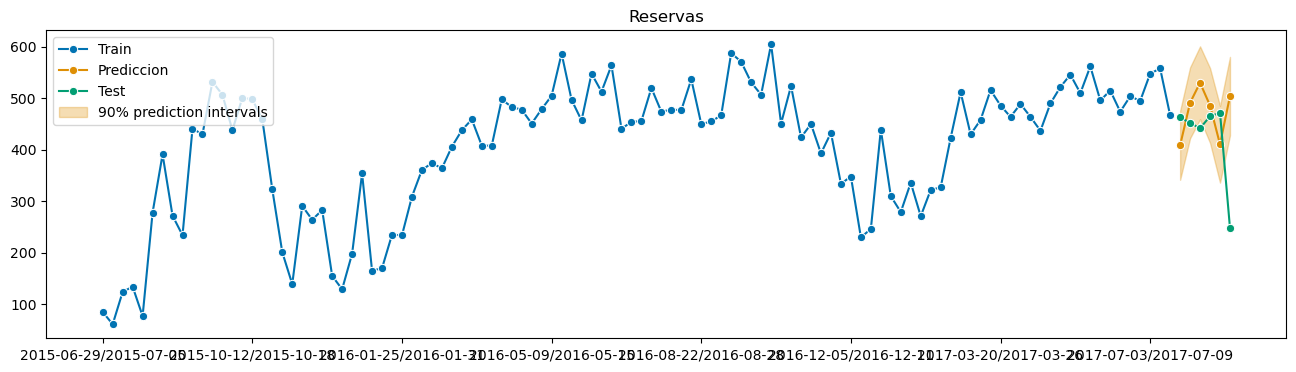

In [149]:
# Generamos los intervalos de predicción
ets_ip = ets_model_res.predict_interval(fh_test_res, coverage=0.9)

# Graficamos las series y predicciones
fig, ax = plot_series(res_train, ets_pred_res, res_test, labels=["Train", "Prediccion", "Test"])

# Rellenamos el área entre los intervalos de predicción
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_ip.iloc[:, 0],  # Accedemos a la primera columna para obtener el límite inferior
    ets_ip.iloc[:, 1],  # Accedemos a la segunda columna para obtener el límite superior
    alpha=0.3,
    color=ax.get_lines()[-2].get_c(),
    label="90% prediction intervals"
)
ax.set_title('Reservas')

# Mostramos la leyenda
ax.legend(loc='upper left')

In [94]:
# Performance
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
RMSE = MeanSquaredError(square_root=True)
MAPE = MeanAbsolutePercentageError(symmetric=False)

def ForecastPerformance(original,forecast):
    print(f'RMSE: {round(RMSE(original, forecast),2)}')
    print(f'MAPE: {round(MAPE(original, forecast)*100,2)}%')

In [95]:
# Calcular Performance

ForecastPerformance(can_test, ets_pred)

RMSE: 212.24
MAPE: 32.81%


### Cross validation ETS

In [96]:
# Cross Validation
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster



# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])
# Defenir el CV
cv = ExpandingWindowSplitter(
    initial_window=50, #60 114
     step_length=1,
    # start_with_window=True,
     fh=fh_test_can) # fh_test 1 
# definir los modelos y los parametros (GRID)
rescv = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
     {
          "forecaster": [ExponentialSmoothing(sp=52)],
          "forecaster__trend": ["add", "mul"],
          "forecaster__damped_trend": [True,False],
          "forecaster__seasonal": ["add", "mul"],
    },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)

In [97]:
# estimar todos los modelos pot CV 
rescv.fit(res_train)  

Fitting 53 folds for each of 11 candidates, totalling 583 fits


c:\Users\Manuel\anaconda3\Lib\site-packages\sktime\forecasting\naive.py:170: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=50),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ExponentialSmoothing(sp=52)],
                                     'forecaster__damped_trend': [True, False],
                                     'forecaster__seasonal': ['add', 'mul'],
                                     'forecaster__trend': ['add', 'mul']}],
                        verbose=1)

In [98]:
# Los resultados
rescv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.171453,0.047488,0.032255,"{'forecaster': NaiveForecaster(sp=52, strategy...",1.0
1,0.227295,0.021130,0.231420,"{'forecaster': NaiveForecaster(sp=52), 'foreca...",2.0
2,0.238064,0.042383,0.029918,"{'forecaster': NaiveForecaster(sp=52, strategy...",3.0
3,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
4,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
5,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
6,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(damped_tre...,NaN
7,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(seasonal='...,NaN
8,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(seasonal='...,NaN
9,NaN,NaN,NaN,{'forecaster': ExponentialSmoothing(seasonal='...,NaN


In [99]:
# el tercer modelo
rescv.cv_results_["params"][3]

{'forecaster': ExponentialSmoothing(damped_trend=True, seasonal='add', sp=52, trend='add'),
 'forecaster__damped_trend': True,
 'forecaster__seasonal': 'add',
 'forecaster__trend': 'add'}

In [100]:
# El performance del mejor modelo
rescv.best_score_

0.17145343816223757

In [101]:
# Predicción
res_cv_pred = rescv.predict(fh=[1,2,3,4,5,6]) 
res_cv_pred


,Bookings
2017-07-24/2017-07-30,470.570093
2017-07-31/2017-08-06,474.140187
2017-08-07/2017-08-13,477.710280
2017-08-14/2017-08-20,481.280374
2017-08-21/2017-08-27,484.850467
2017-08-28/2017-09-03,488.420561


In [156]:

# Performace

ForecastPerformance(res_test, res_cv_pred)

RMSE: 100.05
MAPE: 19.63%


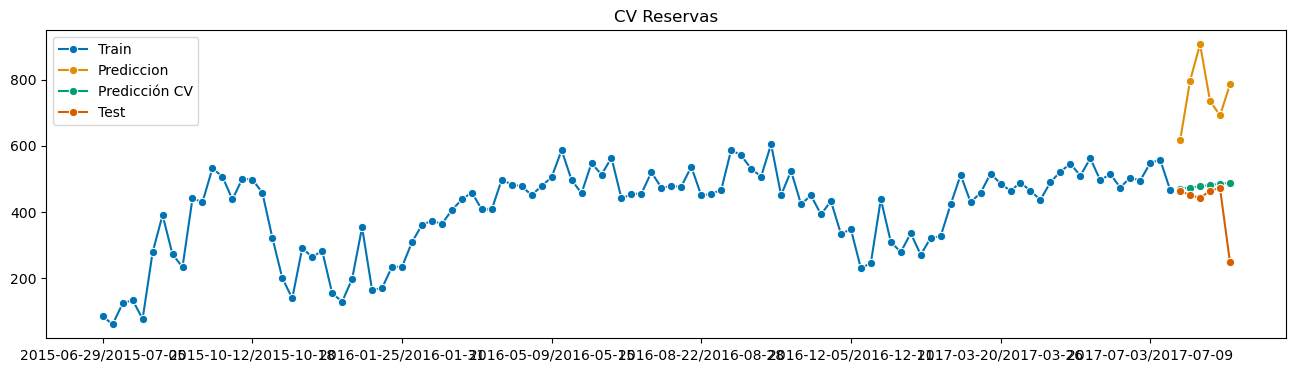

In [164]:
# Grafico zoom de las predicciones
plot_series(res_train, ets_pred, res_cv_pred, res_test, labels=["Train", "Prediccion","Predicción CV", "Test"])
plt.title('CV Reservas')
plt.show()


## ARIMA 


### Cancelaciones

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

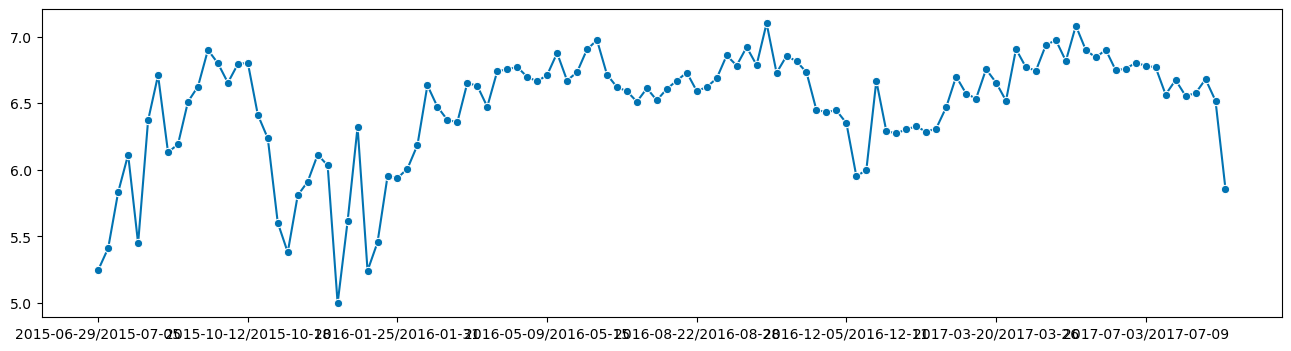

In [104]:
from sktime.transformations.series.boxcox import LogTransformer
# Estacionariedad en Varianza
transformacion = LogTransformer()
log_data_can= transformacion.fit_transform(cancelaciones)
plot_series(log_data_can)

In [106]:
# Sktime Auto ARIMA Function
from sktime.forecasting.arima import AutoARIMA
log_can_train, log_can_test = temporal_train_test_split(y =log_data_can, test_size=6)
#definimos el modelo
arima_model = AutoARIMA(sp=52,suppress_warnings=True,trace=True)
# estimacion
arima_model.fit(log_can_train) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=12.48 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=43.196, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=33.780, Time=3.33 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=26.869, Time=5.71 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=41.388, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=33.222, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=9.47 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=inf, Time=36.19 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=27.301, Time=4.86 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=45.26 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=35.570, Time=6.66 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=27.273, Time=9.49 sec
 ARIMA(0,1,2)(0,0,1)[52] intercept   : AIC=20.817, Time=5.59 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=29.214, Time=0.49 sec
 ARIMA(0,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=19.

AutoARIMA(sp=52, suppress_warnings=True, trace=True)

In [107]:
 # Predicción
fh_test_can=np.arange(1,len(can_test)+1)
log_arima_pred_can = arima_model.predict(fh=fh_test_can)
log_arima_pred_can

,IsCanceled
2017-07-24/2017-07-30,6.656280
2017-07-31/2017-08-06,6.615021
2017-08-07/2017-08-13,6.553375
2017-08-14/2017-08-20,6.656136
2017-08-21/2017-08-27,6.602495
2017-08-28/2017-09-03,6.565806


In [108]:
# Prediccion niveles
arima_pred_can=np.exp(log_arima_pred_can)
arima_pred_can

,IsCanceled
2017-07-24/2017-07-30,777.652307
2017-07-31/2017-08-06,746.220608
2017-08-07/2017-08-13,701.608429
2017-08-14/2017-08-20,777.541028
2017-08-21/2017-08-27,736.931841
2017-08-28/2017-09-03,710.384307


In [109]:
# Calcular Performance

ForecastPerformance(can_test, arima_pred_can)

RMSE: 150.98
MAPE: 20.8%


### Reservas

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

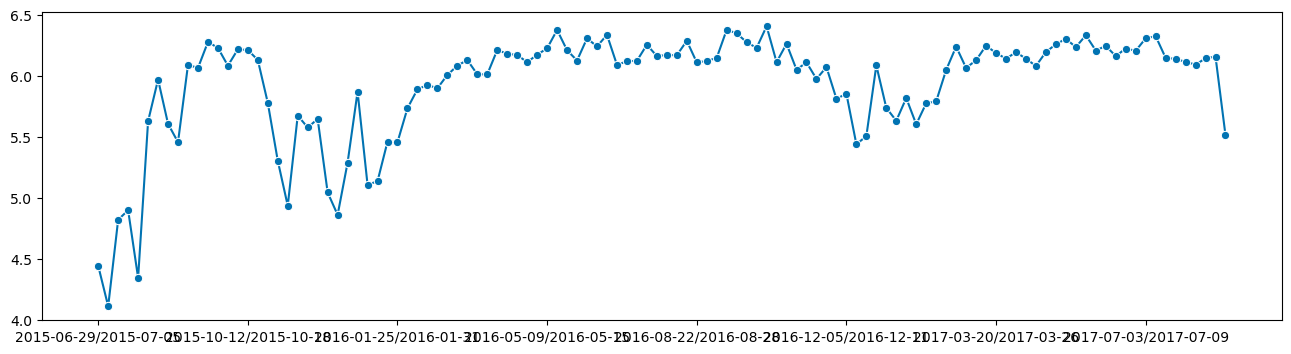

In [110]:
from sktime.transformations.series.boxcox import LogTransformer
# Estacionariedad en Varianza
transformacion = LogTransformer()
log_data_res= transformacion.fit_transform(reservas)
plot_series(log_data_res)

In [111]:
# Sktime Auto ARIMA Function
from sktime.forecasting.arima import AutoARIMA
log_res_train, log_res_test = temporal_train_test_split(y =log_data_res, test_size=6)
#definimos el modelo
arima_model = AutoARIMA(sp=52,suppress_warnings=True,trace=True)
# estimacion
arima_model.fit(log_res_train) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=13.550, Time=19.93 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=26.903, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=23.974, Time=4.52 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=19.069, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=25.277, Time=0.19 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=11.550, Time=15.61 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=12.704, Time=1.21 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=13.550, Time=52.72 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=11.579, Time=27.80 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=15.550, Time=105.68 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AIC=19.200, Time=11.44 sec
 ARIMA(2,1,1)(0,0,1)[52] intercept   : AIC=15.576, Time=11.32 sec
 ARIMA(3,1,2)(0,0,1)[52] intercept   : AIC=13.550, Time=22.80 sec
 ARIMA(2,1,3)(0,0,1)[52] intercept   : AIC=9.348, Time=19.81 sec
 ARIMA(2,1,3)(0,0,0)[52] intercept   :

AutoARIMA(sp=52, suppress_warnings=True, trace=True)

In [112]:
 # Predicción
fh_test_res=np.arange(1,len(res_test)+1)
log_arima_pred_res = arima_model.predict(fh=fh_test_res)
log_arima_pred_res

,Bookings
2017-07-24/2017-07-30,6.175257
2017-07-31/2017-08-06,6.279286
2017-08-07/2017-08-13,6.282591
2017-08-14/2017-08-20,6.231854
2017-08-21/2017-08-27,6.231964
2017-08-28/2017-09-03,6.211564


In [113]:
# Prediccion niveles
arima_pred_res=np.exp(log_arima_pred_res)
arima_pred_res

,Bookings
2017-07-24/2017-07-30,480.706625
2017-07-31/2017-08-06,533.407442
2017-08-07/2017-08-13,535.173740
2017-08-14/2017-08-20,508.697936
2017-08-21/2017-08-27,508.753927
2017-08-28/2017-09-03,498.480216


In [114]:
# Calcular Performance

ForecastPerformance(res_test, arima_pred_res)

RMSE: 116.64
MAPE: 26.85%


## THETA

### Cancelaciones

In [115]:
# SKTIME Theta
from sktime.forecasting.theta import ThetaForecaster
# definimos el modelo
theta_model_can = ThetaForecaster(sp=52)
# estimacion
theta_model_can.fit(can_train) 



ThetaForecaster(sp=52)

In [116]:
theta_model_can.get_fitted_params()

{'initial_level': 233.56464940762896,
 'smoothing_level': 0.601626282910789,
 'deseasonalizer__seasonal': 2015-06-29/2015-07-05    1.006924
 2015-07-06/2015-07-12    0.968670
 2015-07-13/2015-07-19    0.887975
 2015-07-20/2015-07-26    0.975846
 2015-07-27/2015-08-02    0.887976
 2015-08-03/2015-08-09    0.963798
 2015-08-10/2015-08-16    1.022394
 2015-08-17/2015-08-23    1.087989
 2015-08-24/2015-08-30    0.945881
 2015-08-31/2015-09-06    0.970799
 2015-09-07/2015-09-13    1.033574
 2015-09-14/2015-09-20    1.225133
 2015-09-21/2015-09-27    1.133669
 2015-09-28/2015-10-04    1.301053
 2015-10-05/2015-10-11    1.134200
 2015-10-12/2015-10-18    1.549569
 2015-10-19/2015-10-25    1.068111
 2015-10-26/2015-11-01    1.209508
 2015-11-02/2015-11-08    1.155059
 2015-11-09/2015-11-15    1.057654
 2015-11-16/2015-11-22    0.792374
 2015-11-23/2015-11-29    0.779505
 2015-11-30/2015-12-06    0.784102
 2015-12-07/2015-12-13    0.712332
 2015-12-14/2015-12-20    0.478661
 2015-12-21/2015-12-

In [117]:
# Predicción
theta_pred_can = theta_model_can.predict(fh=fh_test_can)
theta_pred_can

,IsCanceled
2017-07-24/2017-07-30,725.649390
2017-07-31/2017-08-06,789.416377
2017-08-07/2017-08-13,839.325851
2017-08-14/2017-08-20,895.212867
2017-08-21/2017-08-27,780.056364
2017-08-28/2017-09-03,802.424445


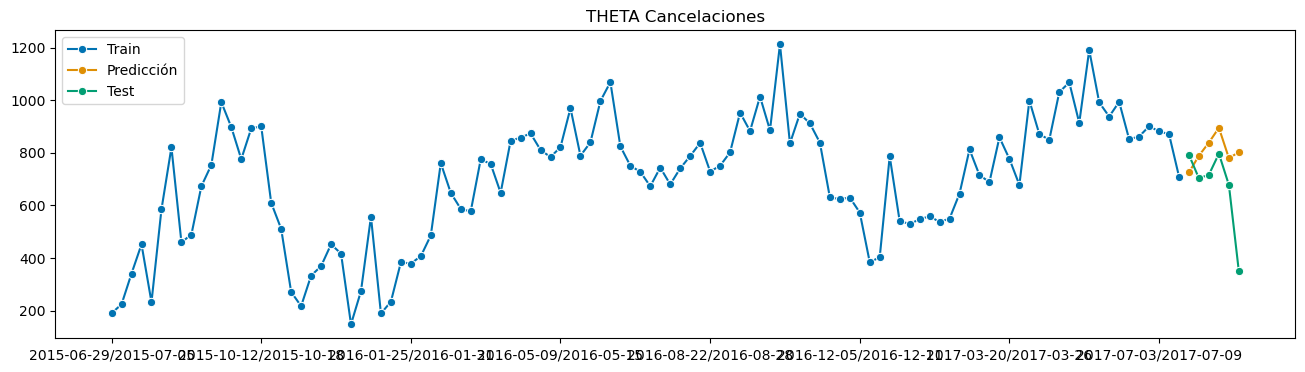

In [166]:
# Realizar la predicción 
theta_pred_res = theta_model_can.predict(fh_test_res)

# Graficar las series y las predicciones
fig, ax = plot_series(can_train, theta_pred_can, can_test, labels=["Train", "Predicción", "Test"])
ax.legend(loc='upper left')
plt.title('THETA Cancelaciones')
plt.show()


In [119]:
# Calcular Performance

ForecastPerformance(can_test, theta_pred_can)

RMSE: 205.14
MAPE: 32.5%


In [120]:
from sktime.forecasting.model_evaluation import evaluate
cv = ExpandingWindowSplitter(initial_window=108, step_length=1, fh=[1])
loss = MeanAbsolutePercentageError(symmetric=False)
results = evaluate(forecaster=theta_model_can, y=cancelaciones, cv=cv, scoring=loss)
results
results.mean()

C:\Users\Manuel\AppData\Local\Temp\ipykernel_20148\1367389717.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results.mean()


test_MeanAbsolutePercentageError      0.242348
fit_time                              0.220066
pred_time                             0.140631
len_train_window                    110.500000
dtype: float64

## Reservas

In [121]:
# SKTIME Theta
from sktime.forecasting.theta import ThetaForecaster
# definimos el modelo
theta_model_res = ThetaForecaster(sp=52)
# estimacion
theta_model_res.fit(res_train) 



ThetaForecaster(sp=52)

In [122]:
theta_model_res.get_fitted_params()

{'initial_level': 89.41111959428999,
 'smoothing_level': 0.5358633005307737,
 'deseasonalizer__seasonal': 2015-06-29/2015-07-05    0.990969
 2015-07-06/2015-07-12    1.015023
 2015-07-13/2015-07-19    1.013834
 2015-07-20/2015-07-26    1.150844
 2015-07-27/2015-08-02    1.045898
 2015-08-03/2015-08-09    1.053581
 2015-08-10/2015-08-16    1.051856
 2015-08-17/2015-08-23    1.183780
 2015-08-24/2015-08-30    0.987777
 2015-08-31/2015-09-06    0.995058
 2015-09-07/2015-09-13    1.020336
 2015-09-14/2015-09-20    1.282584
 2015-09-21/2015-09-27    1.241907
 2015-09-28/2015-10-04    1.151609
 2015-10-05/2015-10-11    1.098458
 2015-10-12/2015-10-18    1.311565
 2015-10-19/2015-10-25    0.978964
 2015-10-26/2015-11-01    1.137470
 2015-11-02/2015-11-08    0.918788
 2015-11-09/2015-11-15    0.973387
 2015-11-16/2015-11-22    0.850742
 2015-11-23/2015-11-29    0.937571
 2015-11-30/2015-12-06    0.721610
 2015-12-07/2015-12-13    0.751761
 2015-12-14/2015-12-20    0.497615
 2015-12-21/2015-12-

In [123]:
res_test

,Bookings
2017-07-24/2017-07-30,463
2017-07-31/2017-08-06,452
2017-08-07/2017-08-13,442
2017-08-14/2017-08-20,465
2017-08-21/2017-08-27,472
2017-08-28/2017-09-03,248


In [124]:
# Predicción
theta_pred_res = theta_model_res.predict(fh=fh_test_res)
theta_pred_res


,Bookings
2017-07-24/2017-07-30,486.704909
2017-07-31/2017-08-06,491.374520
2017-08-07/2017-08-13,491.662211
2017-08-14/2017-08-20,554.555998
2017-08-21/2017-08-27,463.761853
2017-08-28/2017-09-03,468.214012


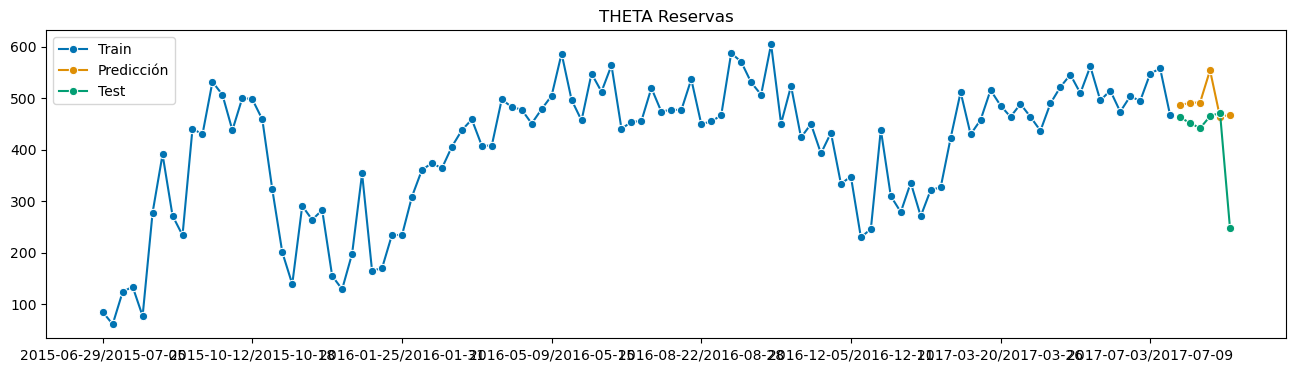

In [167]:
# Realizar la predicción 
theta_pred_res = theta_model_res.predict(fh_test_res)

# Graficar las series y las predicciones
fig, ax = plot_series(res_train, theta_pred_res, res_test, labels=["Train", "Predicción", "Test"])
ax.legend(loc='upper left')
plt.title('THETA Reservas')
plt.show()


In [126]:
# Calcular Performance

ForecastPerformance(res_test, theta_pred_res)

RMSE: 100.96
MAPE: 22.48%


In [127]:
from sktime.forecasting.model_evaluation import evaluate
cv = ExpandingWindowSplitter(initial_window=108, step_length=1, fh=[1])
loss = MeanAbsolutePercentageError(symmetric=False)
results = evaluate(forecaster=theta_model_res, y=reservas, cv=cv, scoring=loss)
results
results.mean()

C:\Users\Manuel\AppData\Local\Temp\ipykernel_20148\776875771.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results.mean()


test_MeanAbsolutePercentageError      0.200972
fit_time                              0.085329
pred_time                             0.034647
len_train_window                    110.500000
dtype: float64

## TBATS

### Cancelaciones

In [128]:
# SKTIME TBATS
from sktime.forecasting.tbats import TBATS
# definimos el modelo
tbats_model = TBATS(  
     use_box_cox=None,
     use_trend=None,
     use_damped_trend=None,
     sp=52,
     use_arma_errors=True, ###
     n_jobs=1)


# estimacion
tbats_model.fit(can_train) 

TBATS(n_jobs=1, sp=52)

In [129]:
# Predicción
tbats_pred_can = tbats_model.predict(fh=fh_test_can)
tbats_pred_can

,IsCanceled
2017-07-24/2017-07-30,781.882384
2017-07-31/2017-08-06,789.943131
2017-08-07/2017-08-13,802.877625
2017-08-14/2017-08-20,824.407234
2017-08-21/2017-08-27,859.482193
2017-08-28/2017-09-03,910.712210


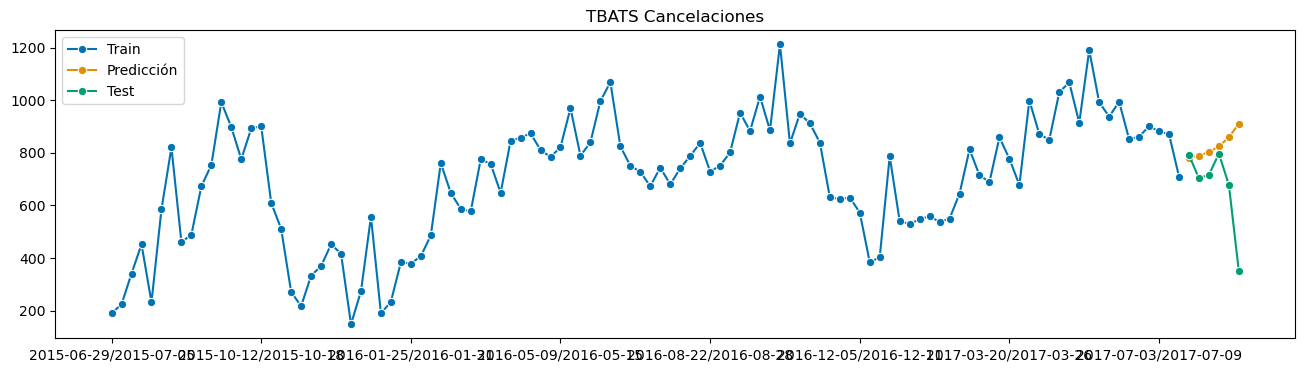

In [169]:

tbats_pred_can = tbats_model.predict(fh_test_can)

# Graficar la serie y las predicciones sin intervalos de confianza
fig, ax = plot_series(can_train, tbats_pred_can, can_test, labels=["Train", "Predicción", "Test"])
ax.legend(loc='upper left')
plt.title('TBATS Cancelaciones')
plt.show()


In [184]:
ForecastPerformance(can_test, tbats_pred_can)

RMSE: 246.39
MAPE: 36.13%


### Reservas

In [131]:
# SKTIME TBATS
from sktime.forecasting.tbats import TBATS
# definimos el modelo
tbats_model_res = TBATS(  
     use_box_cox=None,
     use_trend=None,
     use_damped_trend=None,
     sp=52,
     use_arma_errors=True, ###
     n_jobs=1)


# estimacion
tbats_model_res.fit(res_train) 

TBATS(n_jobs=1, sp=52)

In [146]:
# Predicción
tbats_pred_res = tbats_model_res.predict(fh=fh_test_res)
tbats_pred_res

,Bookings
2017-07-24/2017-07-30,500.321032
2017-07-31/2017-08-06,503.826955
2017-08-07/2017-08-13,511.035652
2017-08-14/2017-08-20,522.976671
2017-08-21/2017-08-27,539.920711
2017-08-28/2017-09-03,560.690357


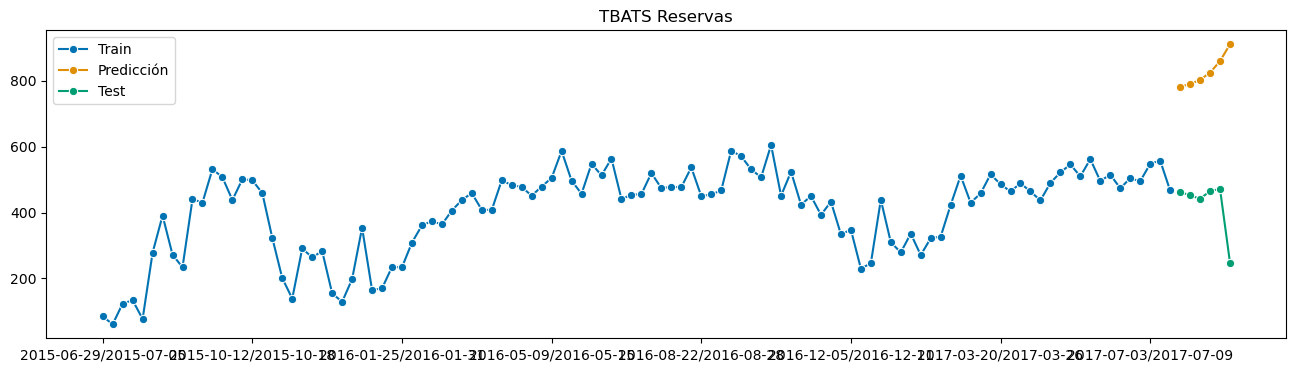

In [170]:

tbats_pred_res = tbats_model.predict(fh_test_can)

# Graficar la serie y las predicciones sin intervalos de confianza
fig, ax = plot_series(res_train, tbats_pred_res, res_test, labels=["Train", "Predicción", "Test"])
ax.legend(loc='upper left')
plt.title('TBATS Reservas')
plt.show()

In [182]:
ForecastPerformance(res_test, tbats_pred_res)

RMSE: 421.23
MAPE: 108.65%


c:\Users\Manuel\anaconda3\Lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
c:\Users\Manuel\anaconda3\Lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


## Graficos comparativos

### Cancelaciones

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

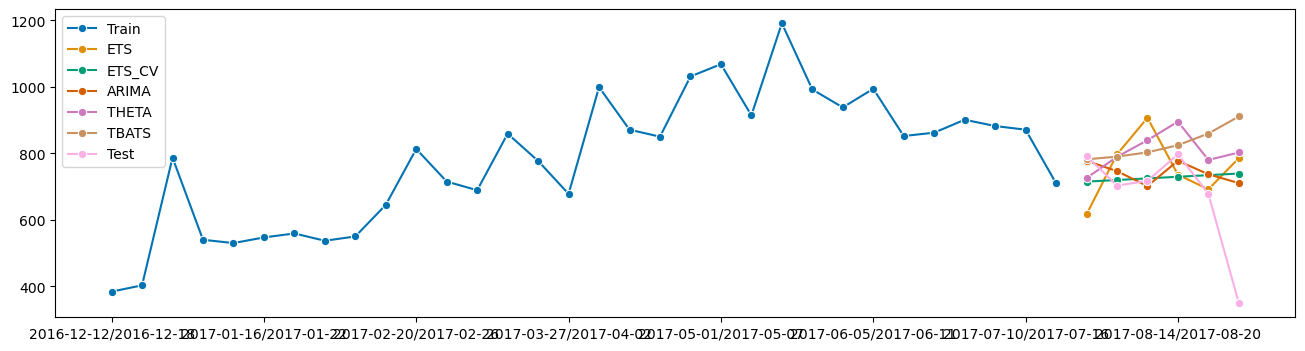

In [161]:
plot_series(can_train[-32:], ets_pred, can_cv_pred,arima_pred_can,theta_pred_can,tbats_pred_can, can_test, 
            labels=["Train", "ETS","ETS_CV","ARIMA","THETA","TBATS","Test"])

### Reservas

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

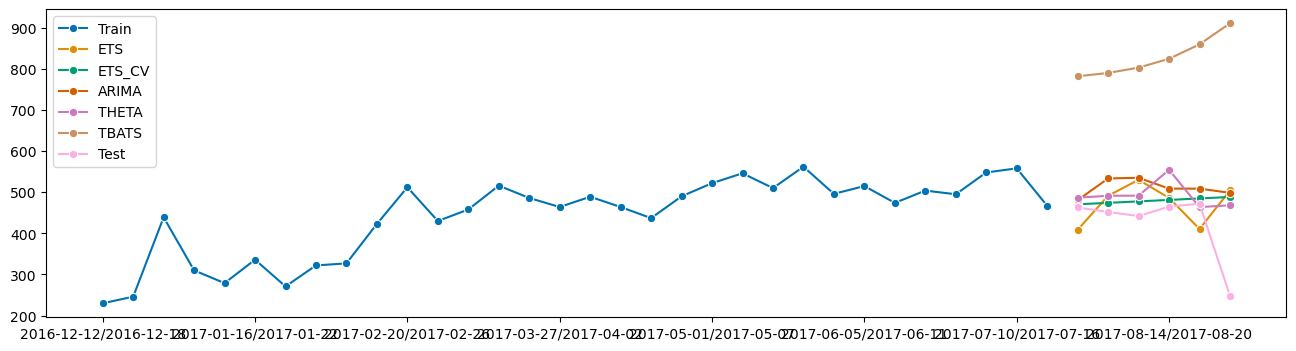

In [181]:
plot_series(res_train[-32:], ets_pred_res, res_cv_pred,arima_pred_res,theta_pred_res, tbats_pred_res, res_test, 
            labels=["Train", "ETS","ETS_CV","ARIMA","THETA","TBATS","Test"])